In [2]:
# Development cell: it automatically reloads modified code in the various modules
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../../")

import numpy as np
import sympy as sp

sp.init_printing()

import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

- True population distribution

$$ X_i \sim p_\text{T}(x) = \mathcal{N}(0,1)$$

- Measurements distribution

$$ X_i^{(m)} \sim p_m(x) = p(x^{(m)} | x) = \mathcal{N}(x^{(m)}, \mu=x,\sigma=\sigma_\text{N})$$

- Model

$$ p(x | \vec{w}) = \sum_{i=1}^{N_w} w_i \delta(x - \hat{x}_i)$$

- We would like to understand which are the most probable weights given the data

$$ p(\vec{w} | \{x_i^{(m)}\}) \propto p(\{x_i^{(m)}\} | \vec{w})\; p(\vec{w})$$

- The right thing to do would be to sample $\vec{w}$ according to $p(\vec{w} | \{x_i^{(m)}\})$
- Alternatively

$$\vec{w}_\text{MAP} = \argmax_{\vec{w}} p(\vec{w} | \{x_i^{(m)}\})$$

- Study the distribution

$$ p(x)_\text{MAP} = p(x | \vec{w}_\text{MAP}) = \sum_{i=1}^{N_w} w_{(\text{MAP}), i} \delta(x - \hat{x}_i)$$

- Let's introduce the moments

$$ p(\vec{w}, \vec{m} | \{x_i^{(m)}\}) \propto p(\{x_i^{(m)}\} | \vec{w})\; p(\vec{w} | \vec{m})\;p(\vec{m})$$

- One could use the maximum entropy principle and maximize the entropy of the above expression subject to contraints

$$ \langle \log p(\vec{w}, \vec{m} | \{x_i^{(m)}\})\rangle_p \propto \langle \log p(\{x_i^{(m)}\} | \vec{w}) \rangle_p + \langle \log p(\vec{w} | \vec{m}) \rangle_p + \langle \log p(\vec{m}) \rangle_p + \sum_k \lambda_k \left(\sum_{i=1}^{N_w} w_i \hat{x}_i^k - m_k\right)$$

- For now we use 

$$ p(\{x_i^{(m)}\} | \vec{w}) = \int \text{d} x\, p(\{x_i^{(m)}\}, x | \vec{w}) = \prod_{i=1}^N \int \text{d} x\, p(x_i^{(m)} | x)\; p(x | \vec{w}) = \prod_{i=1}^N \sum_{j=1}^{N_w} w_j p(x_i^{(m)}| \hat{x}_j) = \prod_{i=1}^N \sum_{j=1}^{N_w} L_{ij} w_j$$

$$ p(\vec{w}, \vec{m} | \{x_i^{(m)}\}) \propto \prod_{i=1}^N \left[\sum_{j=1}^{N_w} L_{ij} w_j\right]\; p(\vec{w} | \vec{m})\;p(\vec{m}) = \prod_{i=1}^N \left[\sum_{j=1}^{N_w} L_{ij} w_j\right]\; p(\vec{w})$$

$$ p(\vec{w} | \{x_i^{(m)}\}) \propto \prod_{i=1}^N \left[\sum_{j=1}^{N_w} L_{ij} w_j\right]\; p(\vec{w})$$


In [3]:
from scipy.stats import norm

N, M = 2 ** 8, 2 ** 0
sigma_noise = 1

p_true = lambda x: norm.pdf(x, loc=0, scale=1)
p_true_range = np.linspace(-8, 8, 2 ** 10)

p_measure = lambda x, x_t: norm.pdf(x, loc=x_t, scale=sigma_noise)

X_true = np.random.normal(loc=0, scale=1, size=N)
X_measure = np.array([np.random.normal(loc=x, scale=sigma_noise, size=M) for x in X_true])

N_w = 9
x_hat = np.linspace(np.amin(X_measure), np.amax(X_measure), N_w)
# x_hat = np.linspace(-8, 8, N_w)
L_ij = np.array([[p_measure(X_measure.ravel()[i], x_hat[j]) for j in range(N_w)] for i in range(N * M)])

`xtol` termination condition is satisfied.
Number of iterations: 314, function evaluations: 323, CG iterations: 320, optimality: 4.97e+01, constraint violation: 0.00e+00, execution time:  0.6 s.


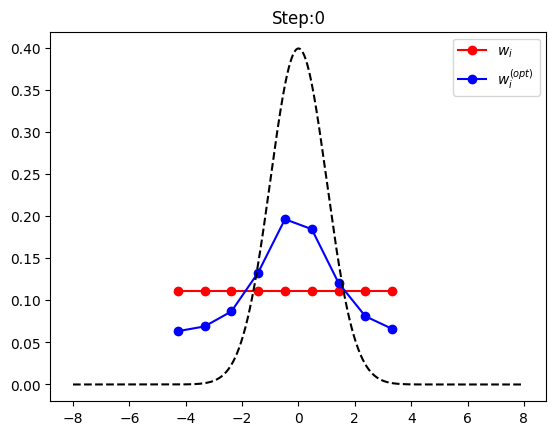

0.0023091474984460944
[ 1.         -0.32116768  4.20572599 -5.22883509 44.28637929]
`xtol` termination condition is satisfied.
Number of iterations: 246, function evaluations: 258, CG iterations: 297, optimality: 6.06e+00, constraint violation: 0.00e+00, execution time: 0.47 s.


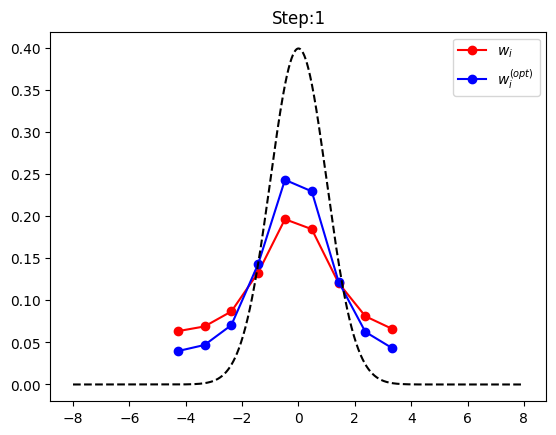

0.000720294122550289
[ 1.         -0.24157293  3.12263942 -3.45042825 29.76067665]
`xtol` termination condition is satisfied.
Number of iterations: 294, function evaluations: 308, CG iterations: 364, optimality: 2.00e+00, constraint violation: 0.00e+00, execution time: 0.55 s.


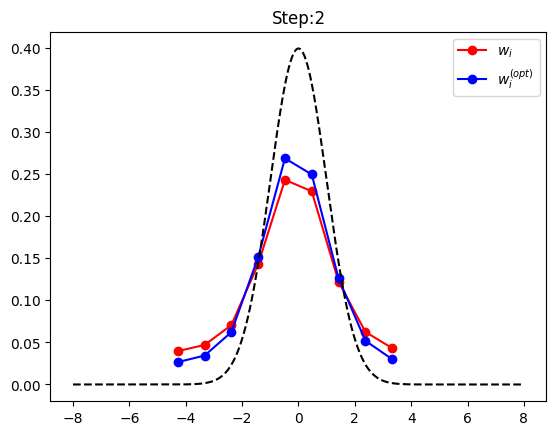

0.000202028823067119
[ 1.         -0.20119816  2.52576938 -2.48115611 21.64580731]
`xtol` termination condition is satisfied.
Number of iterations: 246, function evaluations: 250, CG iterations: 313, optimality: 2.53e+00, constraint violation: 0.00e+00, execution time: 0.45 s.


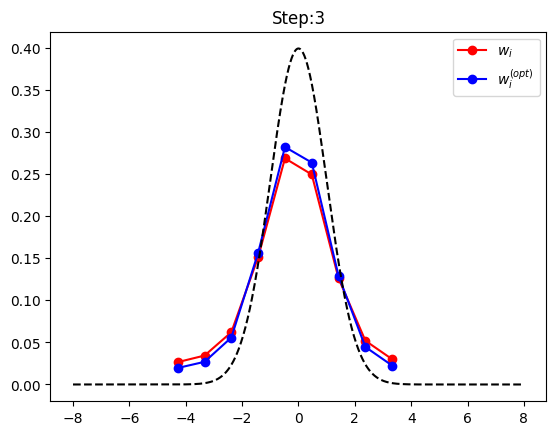

7.453567832047824e-05
[ 1.         -0.17727284  2.17778156 -1.95726431 17.07120922]
`xtol` termination condition is satisfied.
Number of iterations: 313, function evaluations: 320, CG iterations: 373, optimality: 6.95e+00, constraint violation: 0.00e+00, execution time: 0.58 s.


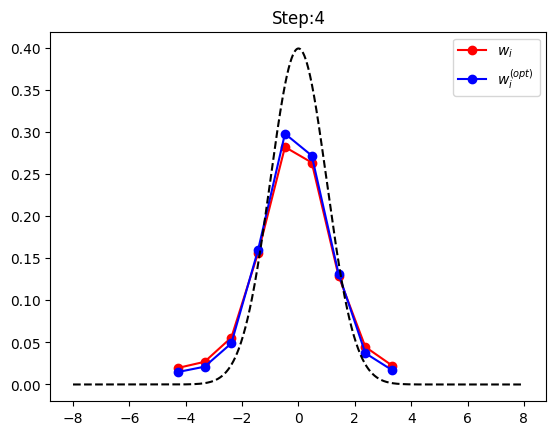

5.862123000823458e-05
[ 1.         -0.16186017  1.90179712 -1.57372023 13.63039742]
`xtol` termination condition is satisfied.
Number of iterations: 320, function evaluations: 329, CG iterations: 374, optimality: 8.17e+00, constraint violation: 0.00e+00, execution time:  0.6 s.


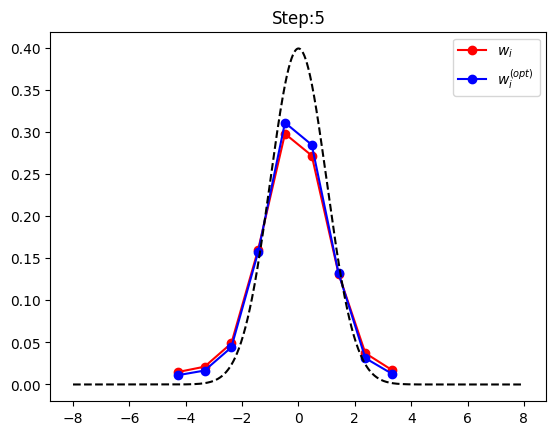

5.0841139429867625e-05
[ 1.         -0.14309009  1.67372846 -1.27561918 10.91487794]
`xtol` termination condition is satisfied.
Number of iterations: 316, function evaluations: 332, CG iterations: 401, optimality: 1.28e+01, constraint violation: 0.00e+00, execution time: 0.59 s.


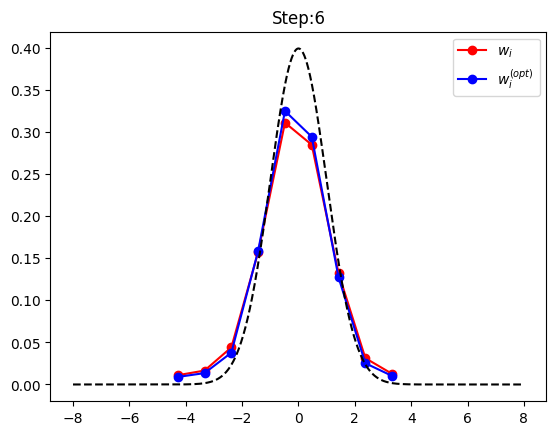

4.5048524205463074e-05
[ 1.         -0.14286521  1.50340729 -1.10557402  9.13581925]
`xtol` termination condition is satisfied.
Number of iterations: 319, function evaluations: 325, CG iterations: 398, optimality: 1.08e+01, constraint violation: 0.00e+00, execution time: 0.59 s.


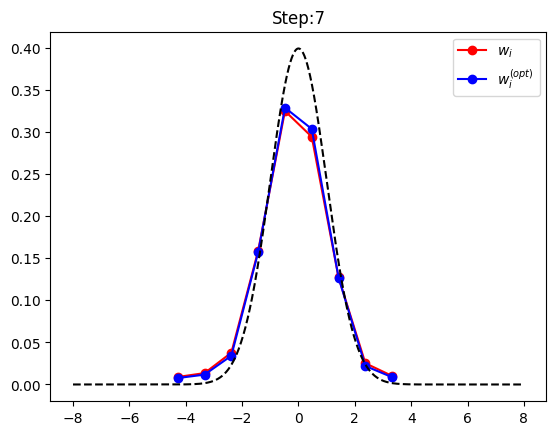

1.5051566065586407e-05
[ 1.         -0.13055489  1.40364037 -0.98171205  8.07074078]


/Users/matteo/github/idea.deploy/py-env/idpy-env/lib/python3.11/site-packages/scipy/optimize/_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


`xtol` termination condition is satisfied.
Number of iterations: 324, function evaluations: 339, CG iterations: 421, optimality: 1.01e+01, constraint violation: 0.00e+00, execution time: 0.61 s.


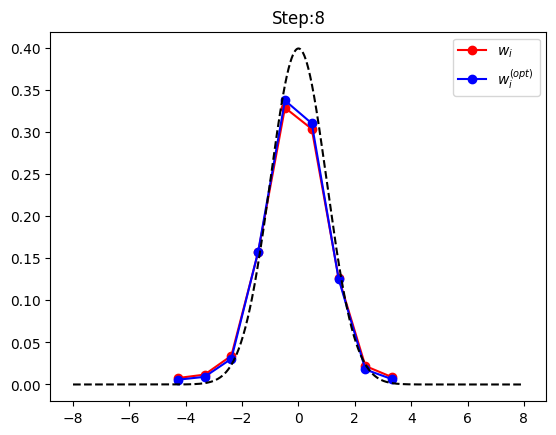

1.8507074838704685e-05
[ 1.         -0.12629732  1.27025042 -0.82787937  6.53412904]
`xtol` termination condition is satisfied.
Number of iterations: 323, function evaluations: 330, CG iterations: 392, optimality: 5.02e+00, constraint violation: 0.00e+00, execution time: 0.61 s.


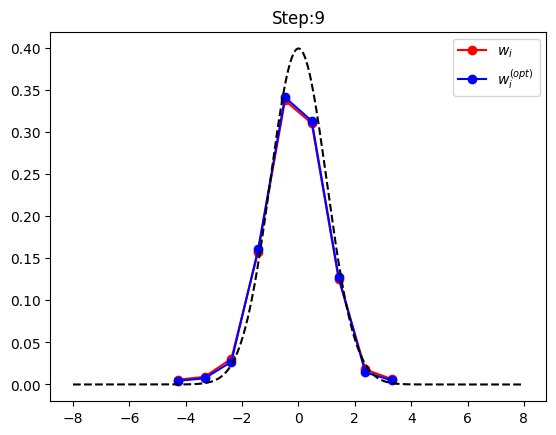

7.377798460909055e-06
[ 1.         -0.12045007  1.183063   -0.71613097  5.51149637]
`xtol` termination condition is satisfied.
Number of iterations: 322, function evaluations: 332, CG iterations: 438, optimality: 7.50e+00, constraint violation: 0.00e+00, execution time: 0.63 s.


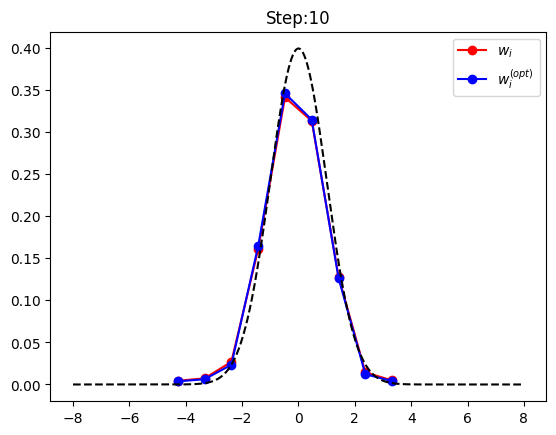

6.684281565435862e-06
[ 1.         -0.12289795  1.12350505 -0.65071259  4.88067982]
`xtol` termination condition is satisfied.
Number of iterations: 291, function evaluations: 291, CG iterations: 294, optimality: 2.53e+01, constraint violation: 0.00e+00, execution time: 0.59 s.


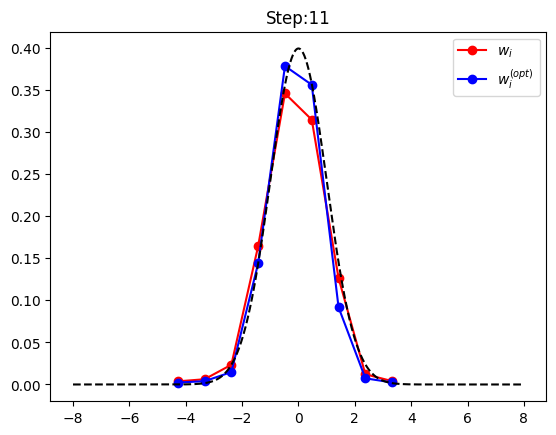

0.0005013178229147579
[ 1.         -0.12153623  0.88253371 -0.49967833  3.27107482]
`xtol` termination condition is satisfied.
Number of iterations: 301, function evaluations: 312, CG iterations: 473, optimality: 1.13e+00, constraint violation: 0.00e+00, execution time: 0.56 s.


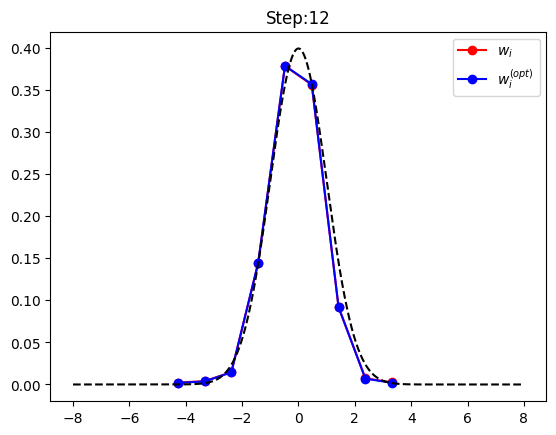

2.0090611874466358e-07
[ 1.         -0.12024326  0.86336953 -0.47061528  2.99602818]
`xtol` termination condition is satisfied.
Number of iterations: 329, function evaluations: 341, CG iterations: 528, optimality: 2.74e+00, constraint violation: 0.00e+00, execution time: 0.62 s.


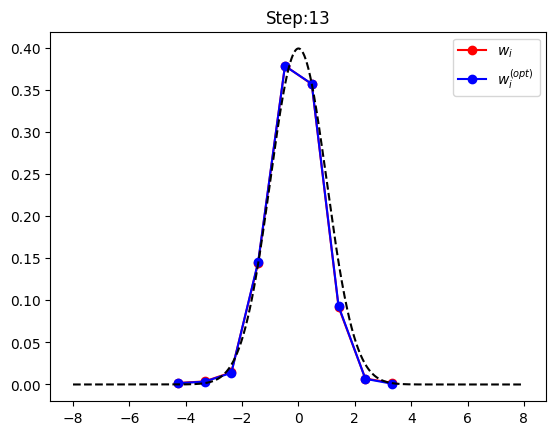

5.207825975294397e-07
[ 1.         -0.12073283  0.84299581 -0.47003275  2.71255384]
`xtol` termination condition is satisfied.
Number of iterations: 351, function evaluations: 364, CG iterations: 747, optimality: 4.13e+00, constraint violation: 0.00e+00, execution time:  0.7 s.


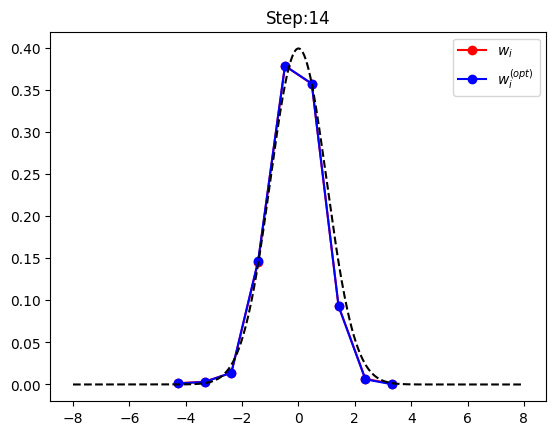

3.1614066312624676e-07
[ 1.         -0.12411078  0.82687565 -0.47207352  2.48564424]


/Users/matteo/github/idea.deploy/py-env/idpy-env/lib/python3.11/site-packages/scipy/optimize/_trustregion_constr/equality_constrained_sqp.py:166: RuntimeWarning: invalid value encountered in scalar subtract
  actual_reduction = merit_function - merit_function_next


The maximum number of function evaluations is exceeded.
Number of iterations: 2048, function evaluations: 2, CG iterations: 18423, optimality: nan, constraint violation: 0.00e+00, execution time:  1.4 s.


ValueError: Optimization failed: The maximum number of function evaluations is exceeded.

In [4]:
from PointMixture import GetCpq
from PointMixture import GetQuadMomentOrthogonalPolynomials
from PointMixture import FindMaxBeta
from PointMixture import SqrtVarBeta
from PointMixture import GetPDFCDFLogW
from PointMixture import GetLogWCorrelations
from PointMixture import find_optimal_w

max_cond = 1e15

w_i_init = np.array([1 / N_w] * N_w)

converged = False
w_i = w_i_init

steps_n = 0
while not converged:
    QuadMS = lambda p, w=w_i, xi=x_hat: np.sum(w * (xi ** p))
        
    q_degree = len(w_i) - 1
    # print(np.array([QuadMS(p) for p in range(4)]))
    
    Cpq = GetCpq(q_degree, QuadMS)
    
    Hm1_T, q_poly_evals = GetQuadMomentOrthogonalPolynomials(x_hat, QuadMS)
    beta_max = FindMaxBeta(q_degree, QuadMS)
    beta = beta_max * 0.1
    sqrt_beta_scale = np.diag(np.array([SqrtVarBeta(p, QuadMS, beta) for p in range(1, q_degree + 1)]))
    Cpq_beta = sqrt_beta_scale @ (Cpq @ sqrt_beta_scale)
    
    ranges_list, pdf_list, cdf_list = GetPDFCDFLogW(Hm1_T, Cpq_beta, q_poly_evals, w_i, max_cond=max_cond)
    cov_logWlogW, corr_logWlogW = GetLogWCorrelations(Hm1_T, Cpq_beta, q_poly_evals, w_i, max_cond=max_cond)
    
    optimal_w, log_post_value, sum_w = \
        find_optimal_w(L_ij, pdf_list, cdf_list, ranges_list, corr_logWlogW, 
                       initial_w=w_i, constrained=True, 
                       solver='trust-constr', debug=False)
        
    plt.figure()
    plt.title("Step:" + str(steps_n))
    plt.plot(x_hat, w_i, 'o-', color='red', label='$w_i$')
    plt.plot(x_hat, optimal_w, 'o-', color='blue', label='$w_i^{(opt)}$')
    plt.plot(p_true_range, p_true(p_true_range), color='black', linestyle='--')
    plt.legend()
    plt.show()
    plt.close()
    
    print(np.mean((w_i - optimal_w) ** 2))

    QuadMS_opt = lambda p, w=optimal_w, xi=x_hat: np.sum(w * (xi ** p))
    print(np.array([QuadMS_opt(p) for p in range(5)]))
    
    w_i = optimal_w
        
    steps_n += 1
    
    if steps_n > 2 ** 4:
        break



In [11]:
from scipy.stats import norm

N, M = 2 ** 9, 2 ** 0
sigma_noise = 1

p_true = lambda x: 0.5 * (norm.pdf(x, loc=-2, scale=1) + norm.pdf(x, loc=2, scale=1))
p_true_range = np.linspace(-8, 8, 2 ** 10)

p_measure = lambda x, x_t: norm.pdf(x, loc=x_t, scale=sigma_noise)

X_true = np.zeros(N)
for i in range(N):
    # Randomly choose which normal distribution to sample from (0 or 1)
    if np.random.rand() < 0.5:
        # Sample from N(-2, 1)
        X_true[i] = np.random.normal(loc=-2, scale=1)
    else:
        # Sample from N(2, 1)
        X_true[i] = np.random.normal(loc=2, scale=1)

X_measure = np.array([np.random.normal(loc=x, scale=sigma_noise, size=M) for x in X_true])

N_w = 10
x_hat = np.linspace(np.amin(X_measure), np.amax(X_measure), N_w)
# x_hat = np.linspace(-8, 8, N_w)
L_ij = np.array([[p_measure(X_measure.ravel()[i], x_hat[j]) for j in range(N_w)] for i in range(N * M)])

`xtol` termination condition is satisfied.
Number of iterations: 327, function evaluations: 327, CG iterations: 315, optimality: 5.96e+01, constraint violation: 0.00e+00, execution time: 0.65 s.


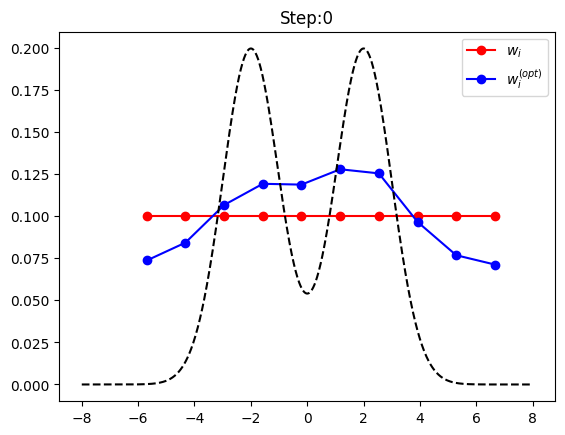

0.0004501763482333902
[  1.           0.41635407  12.95683337  16.83554194 343.80573109]
`xtol` termination condition is satisfied.
Number of iterations: 327, function evaluations: 327, CG iterations: 315, optimality: 4.00e+01, constraint violation: 0.00e+00, execution time: 0.66 s.


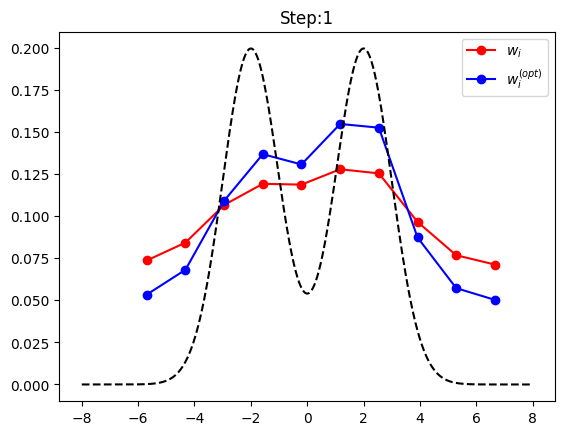

0.0003497454708818441
[  1.           0.38504474  10.65898973  12.59420611 259.6677048 ]
`xtol` termination condition is satisfied.
Number of iterations: 326, function evaluations: 326, CG iterations: 315, optimality: 3.93e+01, constraint violation: 0.00e+00, execution time: 0.64 s.


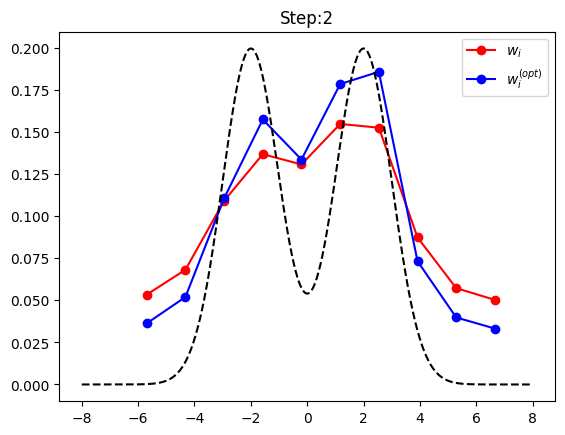

0.00034432381042288245
[  1.           0.36624009   8.65496116   9.07015253 187.29471822]
`xtol` termination condition is satisfied.
Number of iterations: 315, function evaluations: 315, CG iterations: 304, optimality: 7.01e+01, constraint violation: 0.00e+00, execution time: 0.63 s.


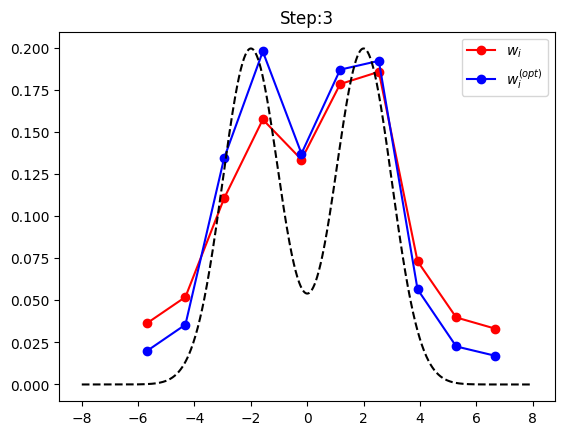

0.0003703961374559424
[  1.           0.15896445   6.72530585   4.47757704 117.53999047]
`xtol` termination condition is satisfied.
Number of iterations: 165, function evaluations: 171, CG iterations: 357, optimality: 5.47e-01, constraint violation: 0.00e+00, execution time: 0.36 s.


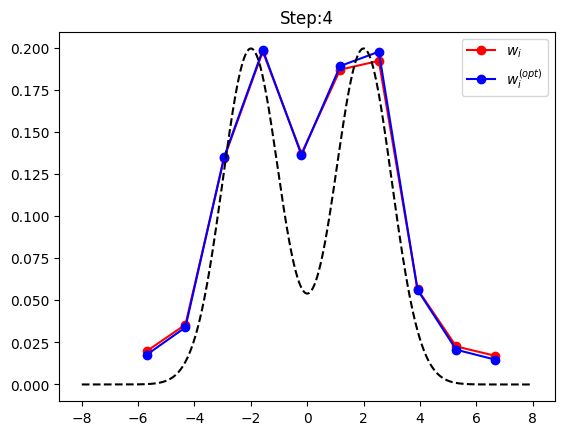

5.24231515111792e-06
[  1.           0.16428355   6.51042717   4.09057129 108.90640114]
`xtol` termination condition is satisfied.
Number of iterations: 193, function evaluations: 199, CG iterations: 380, optimality: 9.65e-01, constraint violation: 0.00e+00, execution time:  0.4 s.


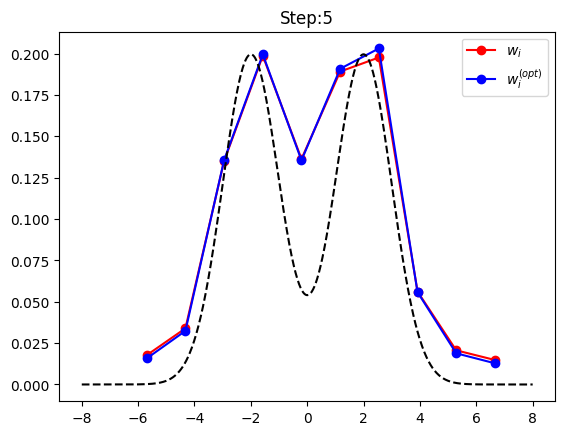

4.746464377621221e-06
[  1.           0.1708745    6.31922191   3.76811159 101.21379819]
`xtol` termination condition is satisfied.
Number of iterations: 214, function evaluations: 224, CG iterations: 393, optimality: 1.52e+00, constraint violation: 0.00e+00, execution time: 0.45 s.


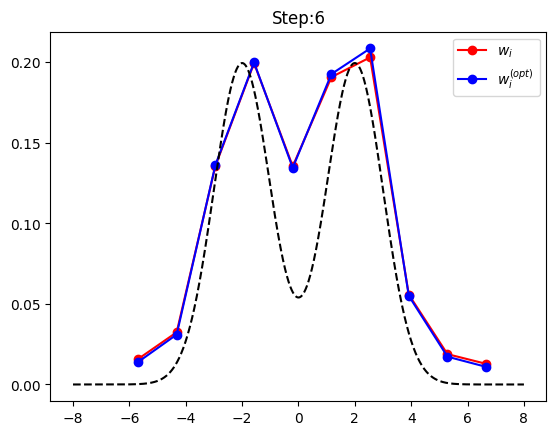

4.755957652319331e-06
[ 1.          0.17762718  6.13748677  3.46520508 93.94491297]
`xtol` termination condition is satisfied.
Number of iterations: 168, function evaluations: 177, CG iterations: 397, optimality: 3.52e-01, constraint violation: 0.00e+00, execution time: 0.39 s.


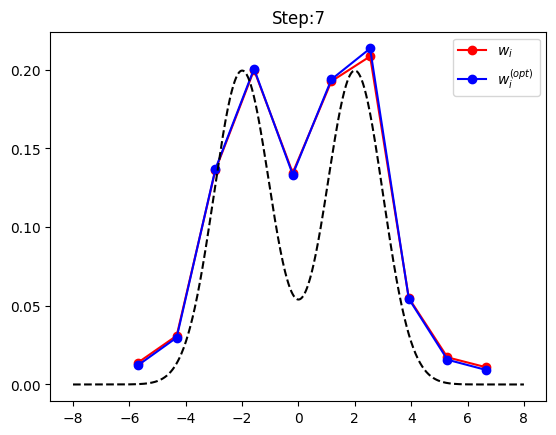

3.833307483317914e-06
[ 1.          0.18208682  5.97649088  3.17994913 87.35764203]
`xtol` termination condition is satisfied.
Number of iterations: 149, function evaluations: 152, CG iterations: 358, optimality: 2.07e-01, constraint violation: 0.00e+00, execution time: 0.36 s.


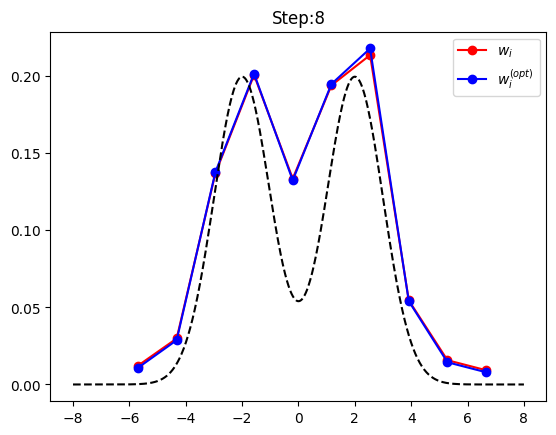

2.8401818045407462e-06
[ 1.          0.18549012  5.84499805  2.95713041 82.00429739]
`xtol` termination condition is satisfied.
Number of iterations: 165, function evaluations: 168, CG iterations: 375, optimality: 8.28e-02, constraint violation: 0.00e+00, execution time: 0.35 s.


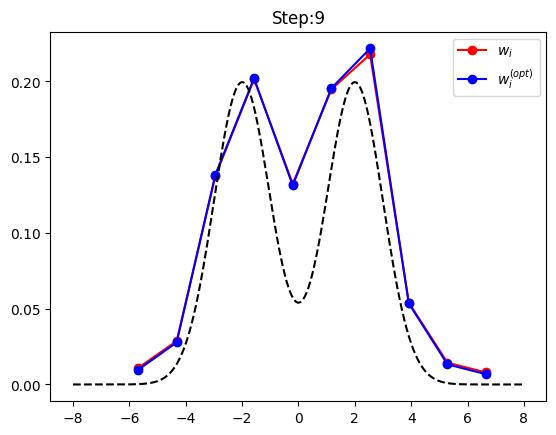

2.2927429297444757e-06
[ 1.          0.18904379  5.73129349  2.76413951 77.33457789]
`xtol` termination condition is satisfied.
Number of iterations: 196, function evaluations: 206, CG iterations: 436, optimality: 1.10e-01, constraint violation: 0.00e+00, execution time: 0.45 s.


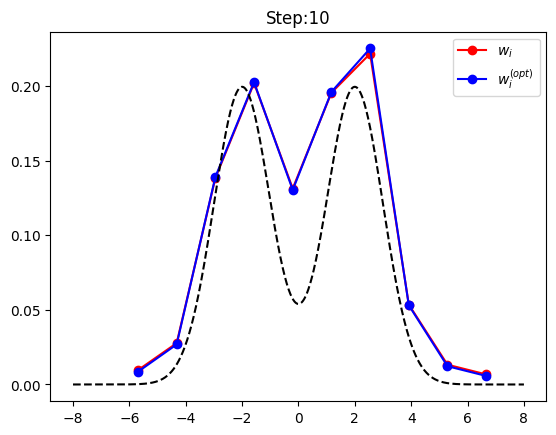

1.8469823970151107e-06
[ 1.          0.19169153  5.63103184  2.59381926 73.21985983]
`xtol` termination condition is satisfied.
Number of iterations: 175, function evaluations: 178, CG iterations: 479, optimality: 8.37e-01, constraint violation: 0.00e+00, execution time: 0.37 s.


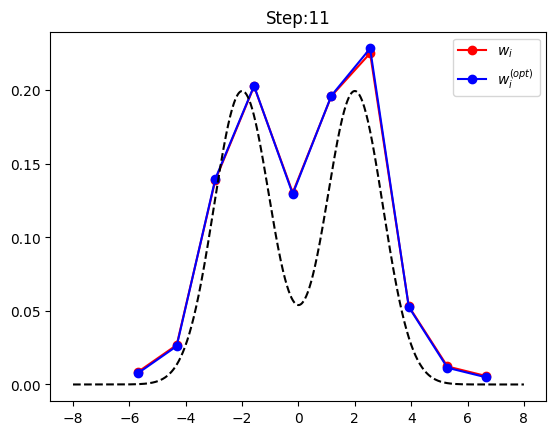

1.516110012376228e-06
[ 1.          0.19378602  5.54753801  2.43983879 69.73577034]
`xtol` termination condition is satisfied.
Number of iterations: 211, function evaluations: 220, CG iterations: 536, optimality: 1.35e+00, constraint violation: 0.00e+00, execution time: 0.47 s.


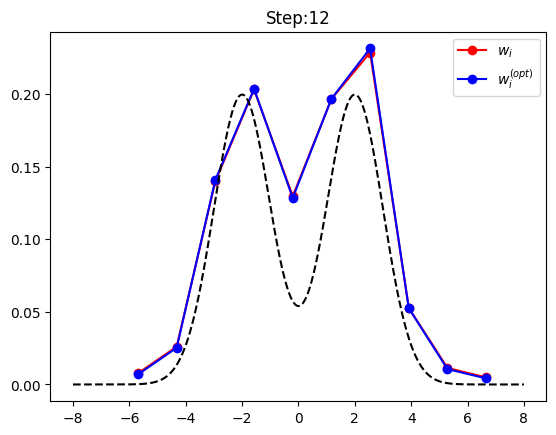

1.2612765172805887e-06
[ 1.          0.19592676  5.47902604  2.32845603 66.80412388]
`xtol` termination condition is satisfied.
Number of iterations: 300, function evaluations: 314, CG iterations: 585, optimality: 2.54e+00, constraint violation: 0.00e+00, execution time: 0.66 s.


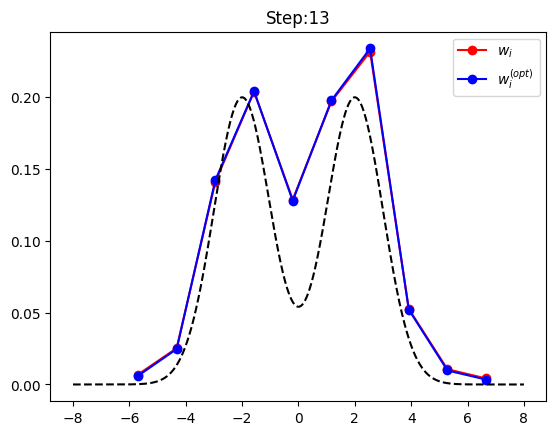

1.014573623793061e-06
[ 1.          0.19503777  5.39812401  2.16749149 63.48558409]
`xtol` termination condition is satisfied.
Number of iterations: 328, function evaluations: 338, CG iterations: 578, optimality: 5.96e+00, constraint violation: 0.00e+00, execution time: 0.68 s.


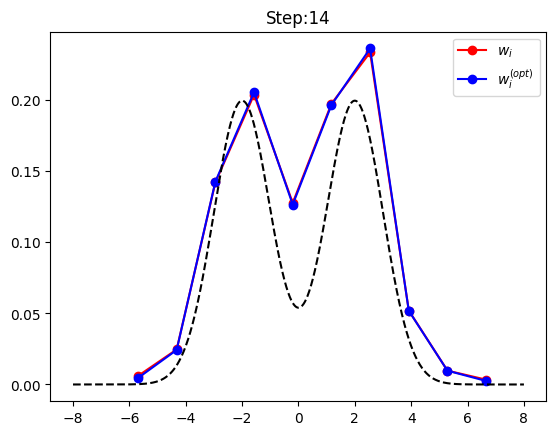

1.6344833161466085e-06
[ 1.          0.19966418  5.32504771  2.20159785 60.11455362]
`xtol` termination condition is satisfied.
Number of iterations: 276, function evaluations: 282, CG iterations: 603, optimality: 2.39e+00, constraint violation: 0.00e+00, execution time: 0.61 s.


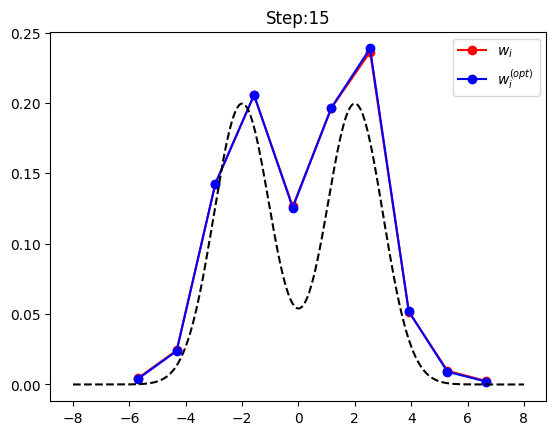

8.125586778982116e-07
[ 1.          0.20486768  5.2784188   2.16343484 58.11964215]
`xtol` termination condition is satisfied.
Number of iterations: 199, function evaluations: 207, CG iterations: 627, optimality: 6.82e-03, constraint violation: 0.00e+00, execution time: 0.45 s.


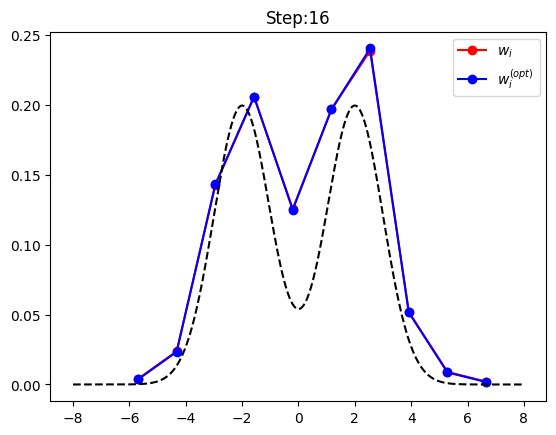

4.164626117587417e-07
[ 1.          0.20573828  5.24374786  2.10222281 56.6500905 ]


In [13]:
from PointMixture import GetCpq
from PointMixture import GetQuadMomentOrthogonalPolynomials
from PointMixture import FindMaxBeta
from PointMixture import SqrtVarBeta
from PointMixture import GetPDFCDFLogW
from PointMixture import GetLogWCorrelations
from PointMixture import find_optimal_w

max_cond = 1e20

w_i_init = np.array([1 / N_w] * N_w)

converged = False
w_i = w_i_init

steps_n = 0
while not converged:
    QuadMS = lambda p, w=w_i, xi=x_hat: np.sum(w * (xi ** p))
        
    q_degree = len(w_i) - 1
    # print(np.array([QuadMS(p) for p in range(4)]))
    
    Cpq = GetCpq(q_degree, QuadMS)
    
    Hm1_T, q_poly_evals = GetQuadMomentOrthogonalPolynomials(x_hat, QuadMS)
    beta_max = FindMaxBeta(q_degree, QuadMS)
    beta = beta_max * 0.1
    sqrt_beta_scale = np.diag(np.array([SqrtVarBeta(p, QuadMS, beta) for p in range(1, q_degree + 1)]))
    Cpq_beta = sqrt_beta_scale @ (Cpq @ sqrt_beta_scale)
    
    ranges_list, pdf_list, cdf_list = GetPDFCDFLogW(Hm1_T, Cpq_beta, q_poly_evals, w_i, max_cond=max_cond)
    cov_logWlogW, corr_logWlogW = GetLogWCorrelations(Hm1_T, Cpq_beta, q_poly_evals, w_i, max_cond=max_cond)
    
    optimal_w, log_post_value, sum_w = \
        find_optimal_w(L_ij, pdf_list, cdf_list, ranges_list, corr_logWlogW, 
                       initial_w=w_i, constrained=True, 
                       solver='trust-constr', debug=False)
        
    plt.figure()
    plt.title("Step:" + str(steps_n))
    plt.plot(x_hat, w_i, 'o-', color='red', label='$w_i$')
    plt.plot(x_hat, optimal_w, 'o-', color='blue', label='$w_i^{(opt)}$')
    plt.plot(p_true_range, p_true(p_true_range), color='black', linestyle='--')
    plt.legend()
    plt.show()
    plt.close()
    
    print(np.mean((w_i - optimal_w) ** 2))

    QuadMS_opt = lambda p, w=optimal_w, xi=x_hat: np.sum(w * (xi ** p))
    print(np.array([QuadMS_opt(p) for p in range(5)]))
    
    w_i = optimal_w
        
    steps_n += 1
    
    if steps_n > 2 ** 4:
        break

